In [22]:
# Instalar PySpark y Matplotlib
!pip install pyspark
!pip install matplotlib

# Importar las librerías necesarias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, abs, dense_rank
import matplotlib.pyplot as plt


#Cargar el archivo CSV y procesar los datos

In [ ]:
from pyspark.sql.functions import date_format

# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("IoT Data Processing") \
    .getOrCreate()

# Cargar los datos desde el archivo CSV
file_path = "G11-Resultado-Mediciones.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Convertir la columna 'hora' para que solo muestre la hora
df = df.withColumn('hora', date_format('hora', 'HH:mm:ss'))

# Mostrar el esquema del DataFrame
df.printSchema()

# Mostrar los primeros registros
df.show()


#Consultas

##Las 5 mediciones de temperatura más altas

In [24]:
# 1. Las 5 mediciones de temperatura más altas
unique_temps = []
seen_temps = set()
for row in temp_highest.collect():
    if row['temp'] not in seen_temps:
        unique_temps.append((row['fecha'], row['hora'], row['temp']))
        seen_temps.add(row['temp'])
    if len(unique_temps) >= 5:
        break
schema = ["fecha", "hora", "temp"]
unique_temps_df = spark.createDataFrame(unique_temps, schema)
unique_temps_df.show()

+----------+--------+-----------+
|     fecha|    hora|       temp|
+----------+--------+-----------+
|2024-07-11|00:33:47|22.79999924|
|2024-07-11|00:33:07|22.70000076|
|2024-07-11|00:35:08|22.60000038|
|2024-07-11|00:35:38|       22.5|
|2024-07-11|00:38:18|22.39999962|
+----------+--------+-----------+



##Las 5 mediciones de calidad de aire más bajas

In [25]:
# 2. Las 5 mediciones de calidad de aire más bajas
air_quality_lowest = df.orderBy(col("calAire").asc()).select("fecha", "hora", "calAire").limit(5)
air_quality_lowest.show()


+----------+--------+-----------+
|     fecha|    hora|    calAire|
+----------+--------+-----------+
|2024-07-11|00:31:57|11.35253906|
|2024-07-11|00:32:07|   11.71875|
|2024-07-11|00:32:27|14.40429688|
|2024-07-11|00:32:37|14.40429688|
|2024-07-11|00:32:17|15.13671875|
+----------+--------+-----------+



##Fecha de la mejor condición atmosférica

In [26]:
# 3. Fecha de la mejor condición atmosférica
df = df.withColumn("Temperatura_Ideal", abs(col("temp") - 25))
df = df.withColumn("Condicion_Atmosferica", col("Temperatura_Ideal") + col("calAire"))
best_condition = df.orderBy(col("Condicion_Atmosferica").asc()).select("fecha", "hora", "temp", "hum", "calAire").limit(1)
best_condition.show()


+----------+--------+-----------+---+-----------+
|     fecha|    hora|       temp|hum|    calAire|
+----------+--------+-----------+---+-----------+
|2024-07-11|00:31:57|22.29999924| 95|11.35253906|
+----------+--------+-----------+---+-----------+



#Consultas adicionales

##Promedio de temperatura por día

In [27]:
# 4. Promedio de temperatura por día
avg_temp_by_day = df.groupBy("fecha").avg("temp").orderBy("fecha")
avg_temp_by_day.show()

+----------+------------------+
|     fecha|         avg(temp)|
+----------+------------------+
|2024-07-09|20.916981014258038|
|2024-07-10|20.741285398671337|
|2024-07-11| 20.59801012774054|
+----------+------------------+



##Promedio de humedad por día

In [28]:
# 5. Promedio de humedad por día
avg_humidity_by_day = df.groupBy("fecha").avg("hum").orderBy("fecha")
avg_humidity_by_day.show()

+----------+-----------------+
|     fecha|         avg(hum)|
+----------+-----------------+
|2024-07-09|78.31361550229475|
|2024-07-10|77.48586118251929|
|2024-07-11|83.18724448078495|
+----------+-----------------+



##Promedio de calidad de aire por día

In [29]:
# 6. Promedio de calidad de aire por día
avg_air_quality_by_day = df.groupBy("fecha").avg("calAire").orderBy("fecha")
avg_air_quality_by_day.show()

+----------+-----------------+
|     fecha|     avg(calAire)|
+----------+-----------------+
|2024-07-09| 35.1391937719478|
|2024-07-10| 32.8894607830524|
|2024-07-11|28.77562245671615|
+----------+-----------------+



#Visualización de los resultados

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
file_path = 'G11-Resultado-Mediciones.csv'
data = pd.read_csv(file_path)

# Convertir 'fecha' y 'hora' a formato datetime
data['datetime'] = pd.to_datetime(data['fecha'] + ' ' + data['hora'])

# Ordenar los datos por 'datetime'
data = data.sort_values(by='datetime')


##Gráficos de series de tiempo

###Evolución de la Calidad del Aire a lo largo del Tiempo

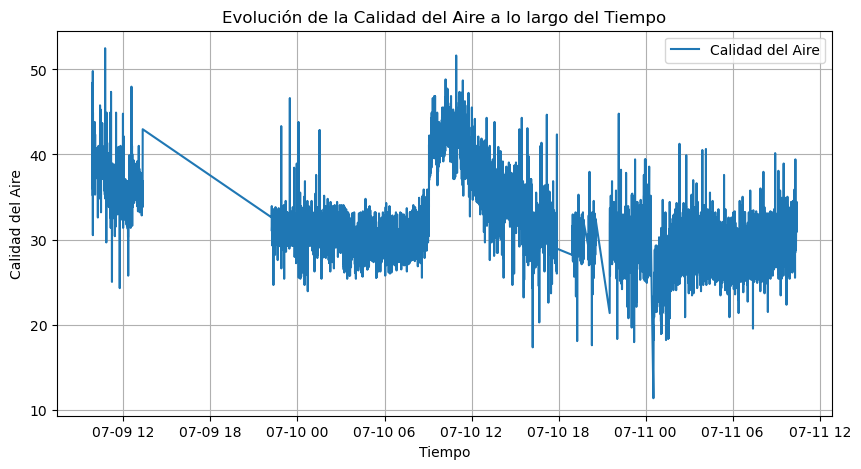

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(data['datetime'], data['calAire'], label='Calidad del Aire')
plt.xlabel('Tiempo')
plt.ylabel('Calidad del Aire')
plt.title('Evolución de la Calidad del Aire a lo largo del Tiempo')
plt.legend()
plt.grid(True)
plt.show()

###Evolución de la Humedad a lo largo del Tiempo

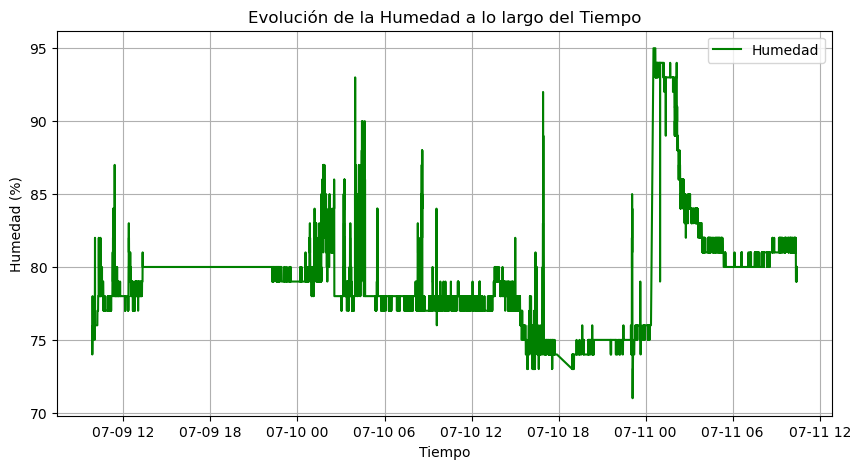

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(data['datetime'], data['hum'], label='Humedad', color='green')
plt.xlabel('Tiempo')
plt.ylabel('Humedad (%)')
plt.title('Evolución de la Humedad a lo largo del Tiempo')
plt.legend()
plt.grid(True)
plt.show()

###Evolución de la Temperatura a lo largo del Tiempo

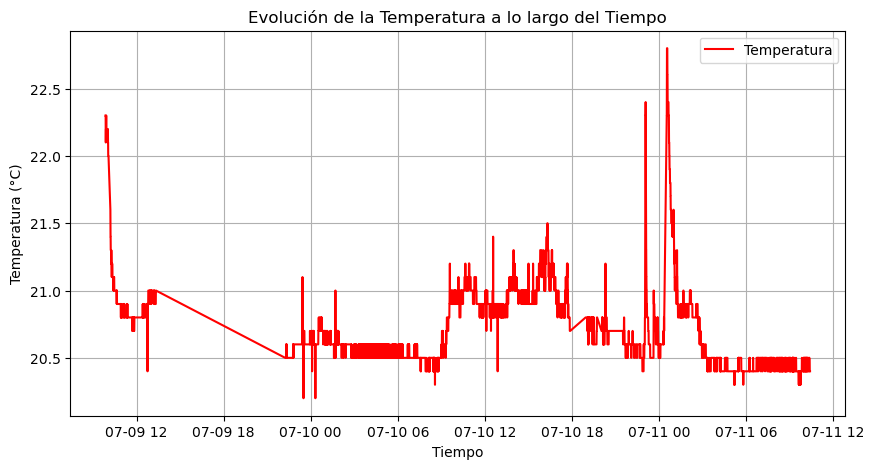

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(data['datetime'], data['temp'], label='Temperatura', color='red')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.title('Evolución de la Temperatura a lo largo del Tiempo')
plt.legend()
plt.grid(True)
plt.show()

##Histogramas

###Distribución de la Calidad del Aire

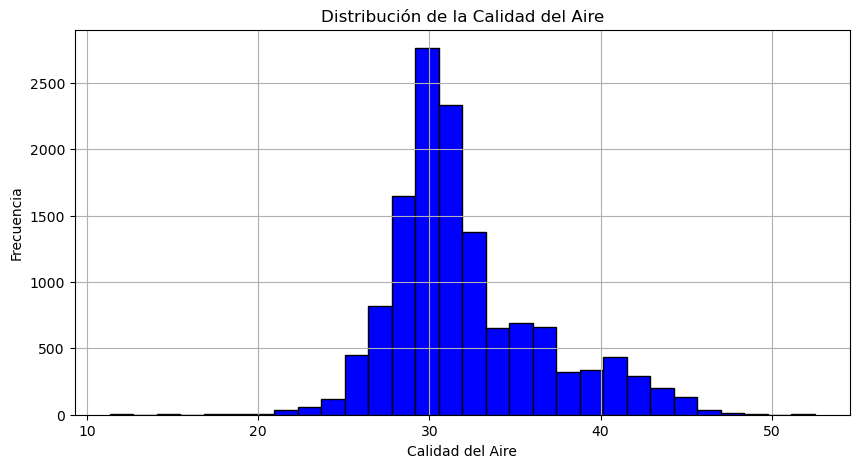

In [35]:
plt.figure(figsize=(10, 5))
plt.hist(data['calAire'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Calidad del Aire')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Calidad del Aire')
plt.grid(True)
plt.show()

###Distribución de la Humedad

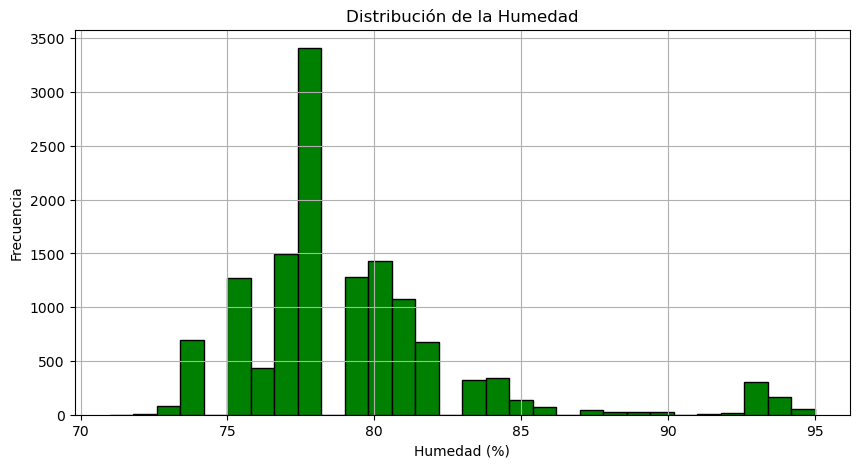

In [36]:
plt.figure(figsize=(10, 5))
plt.hist(data['hum'], bins=30, color='green', edgecolor='black')
plt.xlabel('Humedad (%)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Humedad')
plt.grid(True)
plt.show()

###Distribución de la Temperatura

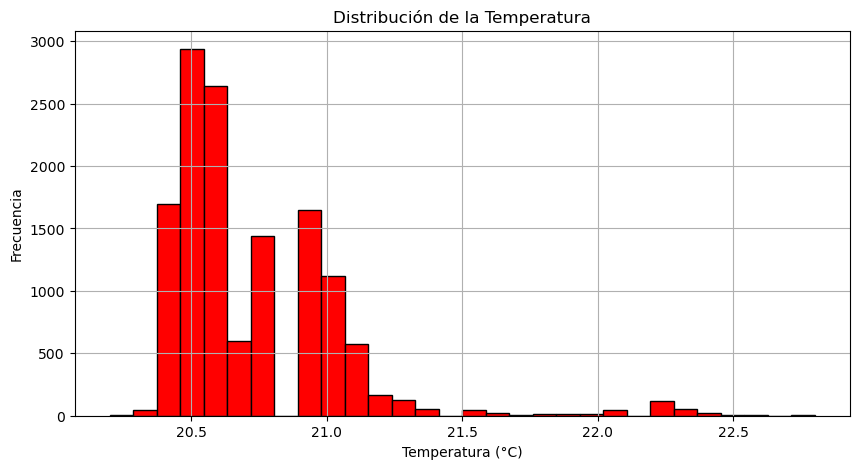

In [37]:
plt.figure(figsize=(10, 5))
plt.hist(data['temp'], bins=30, color='red', edgecolor='black')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Temperatura')
plt.grid(True)
plt.show()

## Gráficos de dispersión

###Relación entre Calidad del Aire y Humedad

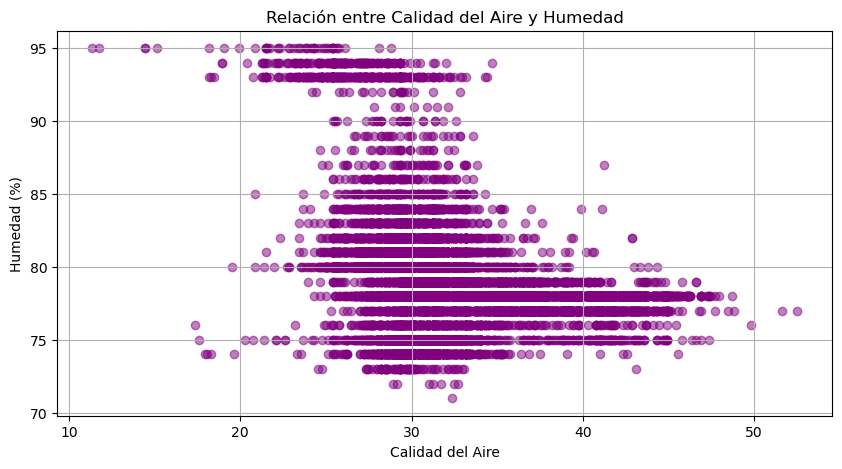

In [38]:
plt.figure(figsize=(10, 5))
plt.scatter(data['calAire'], data['hum'], alpha=0.5, color='purple')
plt.xlabel('Calidad del Aire')
plt.ylabel('Humedad (%)')
plt.title('Relación entre Calidad del Aire y Humedad')
plt.grid(True)
plt.show()

###Relación entre Calidad del Aire y Temperatura

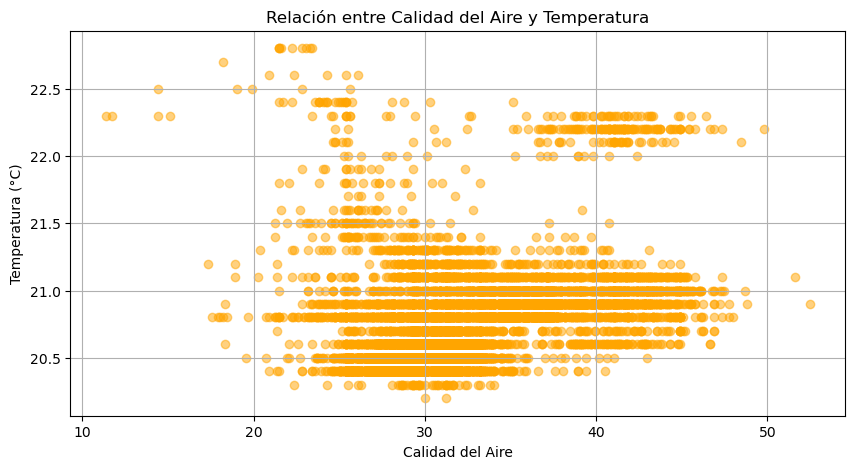

In [39]:
plt.figure(figsize=(10, 5))
plt.scatter(data['calAire'], data['temp'], alpha=0.5, color='orange')
plt.xlabel('Calidad del Aire')
plt.ylabel('Temperatura (°C)')
plt.title('Relación entre Calidad del Aire y Temperatura')
plt.grid(True)
plt.show()

###Relación entre Humedad y Temperatura

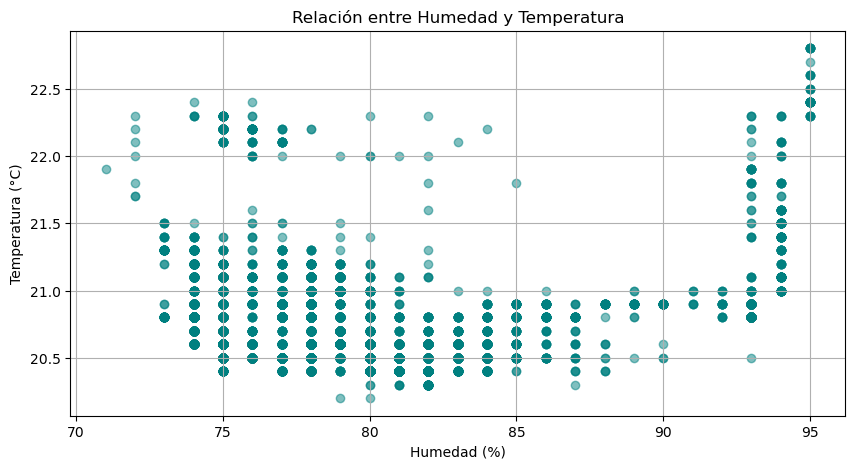

In [40]:
plt.figure(figsize=(10, 5))
plt.scatter(data['hum'], data['temp'], alpha=0.5, color='teal')
plt.xlabel('Humedad (%)')
plt.ylabel('Temperatura (°C)')
plt.title('Relación entre Humedad y Temperatura')
plt.grid(True)
plt.show()